 # Vehicle Routing Problem
 VRP with:
 - [x] Pickups and Deliveries Constraints
 - [x] Capacity Constraints
 - [x] Time Window Constraints
 - [x] Rescource Constraints
 - [x] Penalties And Dropping Visits

 ## Imports
 Import all the required libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

FROM_GOOGLE_MAPS = True

if FROM_GOOGLE_MAPS: 
    from distance_matrix_maps import data
else:
    from distance_matrix_manual import data


Reading/Getting file [./json/distance_matrix_fix_00.json]
Reading/Getting file [./json/distance_matrix_fix_01.json]
Reading/Getting file [./json/distance_matrix_fix_02.json]
Reading/Getting file [./json/distance_matrix_fix_10.json]
Reading/Getting file [./json/distance_matrix_fix_11.json]
Reading/Getting file [./json/distance_matrix_fix_12.json]
Reading/Getting file [./json/distance_matrix_fix_20.json]
Reading/Getting file [./json/distance_matrix_fix_21.json]
Reading/Getting file [./json/distance_matrix_fix_22.json]
Distance matrix shape: (25, 25), Max: 1293
Time matrix shape: (25, 25), Max: 21
{'lat': 53.1337756, 'lng': 23.1511134}
{'lat': 53.145105799999996, 'lng': 23.1326009}
{'lat': 53.143797, 'lng': 23.177726999999997}
{'lat': 53.143589899999995, 'lng': 23.106368899999996}
{'lat': 53.114585299999995, 'lng': 23.147187}
{'lat': 53.1289094, 'lng': 23.153457}
{'lat': 53.137478, 'lng': 23.114635099999997}
{'lat': 53.1396207, 'lng': 23.1275457}
{'lat': 53.1225543, 'lng': 23.1524315}
{'l

 ## Prepare the data
 Define model values

In [2]:
locations = np.array(data['locations'])
data['num_vehicles'] = 4
data['depot'] = 0
data['vehicle_load_time'] = 2
data['vehicle_unload_time'] = 3
data['depot_capacity'] = 2


 Add pickup-delivery request

In [3]:
data['pickups_deliveries'] = [
    [1, 6],
    [2, 10],
    [4, 3],
    [5, 9],
    [7, 8],
    [15, 11],
    [13, 12],
    [16, 14],
]
data['pickups_deliveries']


[[1, 6], [2, 10], [4, 3], [5, 9], [7, 8], [15, 11], [13, 12], [16, 14]]

 Add Time Window for pickups.
 data['time_windows'] =  [(0, 300)] * 25

In [4]:
data['time_windows'] = [
    (0, 60),     # depot
    (0, 90),    # 1
    (3, 6),   # 2
    (6, 180),   # 3
    (0, 30),     # 4
    (0, 180),     # 5
    (20, 50),    # 6
    (15, 100),     # 7
    (14, 110),    # 8
    (3, 150),     # 9
    (1, 100),   # 10
    (16, 310),   # 11
    (0, 1),     # 12
    (2, 70),    # 13
    (1, 30),     # 14
    (2, 60),   # 15
    (3, 50),   # 16
    (5, 90),    # 17
    (8, 120),   # 18
    (7, 80),   # 19
    (6, 70),   # 20
    (12, 140),     # 21
    (10, 120),    # 22
    (6, 70),     # 23
    (2, 60)    # 24
]
data['time_windows']


[(0, 60),
 (0, 90),
 (3, 6),
 (6, 180),
 (0, 30),
 (0, 180),
 (20, 50),
 (15, 100),
 (14, 110),
 (3, 150),
 (1, 100),
 (16, 310),
 (0, 1),
 (2, 70),
 (1, 30),
 (2, 60),
 (3, 50),
 (5, 90),
 (8, 120),
 (7, 80),
 (6, 70),
 (12, 140),
 (10, 120),
 (6, 70),
 (2, 60)]

 Add capacity request

In [5]:
MIN_LOAD_SIZE = 3
MAX_LOAD_SIZE = 6
data['vehicle_capacities'] = [20] * data['num_vehicles']
data['demands'] = [0] * len(data['locations'])
for (i, j) in data['pickups_deliveries']:
    demand = np.random.randint(MIN_LOAD_SIZE, MAX_LOAD_SIZE + 1)
    data['demands'][i] += demand
    data['demands'][j] += -demand # + np.random.randint(MIN_LOAD_SIZE, MAX_LOAD_SIZE + 1)
data['demands']



[0,
 6,
 4,
 -5,
 5,
 6,
 -6,
 3,
 -3,
 -6,
 -4,
 -3,
 -5,
 5,
 -6,
 3,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

 Create the routing index manager.

In [6]:
manager = pywrapcp.RoutingIndexManager(
    len(data['time_matrix']),
    data['num_vehicles'], 
    data['depot']
)


 ## Visualize the problem

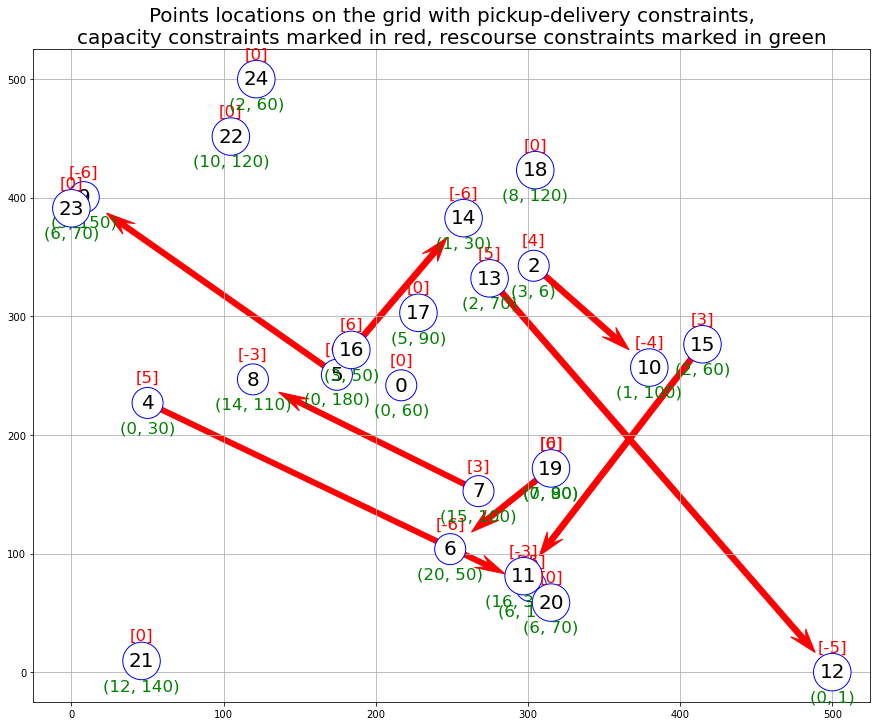

In [7]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(*locations.T)
marker_size = 20
for i, loc in enumerate(locations):
    ax.annotate(
        s=f"{i}", 
        xy=loc, 
        xycoords='data',
        va='center',
        ha='center',
        size=marker_size,
        bbox=dict(boxstyle='circle', fc='w', ec='b'))
    ax.annotate(
        s=f"[{data['demands'][i]}]", 
        xy=loc, 
        xytext=(0, marker_size + 5),
        xycoords='data',
        textcoords='offset points',
        va='center',
        ha='center',
        size=marker_size / 1.2,
        color='red')
    ax.annotate(
        s=f"{data['time_windows'][i]}", 
        xy=loc, 
        xytext=(0, -(marker_size + 5)),
        xycoords='data',
        textcoords='offset points',
        va='center',
        ha='center',
        size=marker_size / 1.2,
        color='green')
for pd_request in data['pickups_deliveries']:
    arrow = np.array([
        locations[pd_request[0]], 
        locations[pd_request[1]] - locations[pd_request[0]]
    ])
    arrow_length = np.linalg.norm(arrow[1])
    arrow_scale = (arrow_length - marker_size) / arrow_length
    ax.arrow(
        *arrow[0],
        *(arrow[1] * arrow_scale),
        color='red',
        width=4,
        head_width=12,
        head_length=20,
        overhang=.3,
        length_includes_head=True,
    )
ax.grid(which='both')
ax.set_title(
'''Points locations on the grid with pickup-delivery constraints,
capacity constraints marked in red, rescourse constraints marked in green''', 
    fontsize=20)
plt.show()


 ## Create Routing Model

In [8]:
routing = pywrapcp.RoutingModel(manager)


 ### Create and register a distance transit callback.

In [9]:
def distance_callback(from_index, to_index):
    """
    Returns the distance between the two nodes.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

distance_callback_index = routing.RegisterTransitCallback(distance_callback)


 ### Create and register a time transit callback.

In [10]:
def time_callback(from_index, to_index):
    """
    Returns the time between the two nodes.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

time_callback_index = routing.RegisterTransitCallback(time_callback)


 ### Define cost of each arc as time between two nodes.

In [11]:
routing.SetArcCostEvaluatorOfAllVehicles(time_callback_index)


 ### Create and register a capacity demand callback.

In [12]:
def demand_callback(from_index):
    """
    Returns the demand of the node.
    """
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)


 ### Add Distance constraint.

In [13]:
dimension_name = 'Distance'
routing.AddDimension(
    distance_callback_index,
    0,      # no slack
    100000,   # vehicle maximum travel distance
    True,   # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)


 ### Add Demand constraint.

In [14]:
dimension_name = 'Capacity'
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,                          # no slack
    data['vehicle_capacities'], # vehicle maximum capacities
    True,                       # start cumul to zero
    dimension_name)
demand_dimension = routing.GetDimensionOrDie(dimension_name)


 ### Add Time Window constraint.

In [15]:
dimension_name = 'Time'
routing.AddDimension(
    time_callback_index,
    3000,     # allow waiting time
    3000,     # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    dimension_name)
time_dimension = routing.GetDimensionOrDie(dimension_name)


 Add time window constraints for each location except depot.

In [16]:
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == data['depot']:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    print(index)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 Add time window constraints for each vehicle start node.

In [17]:
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(*(data['time_windows'][data['depot']]))


 Add resource constraint at the depot.

In [18]:
solver = routing.solver()
intervals = []
for i in range(data['num_vehicles']):
    # Add time windows at start of routes
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.Start(i)),
            data['vehicle_load_time'], 'depot_interval'))
    # Add time windows at end of routes.
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.End(i)),
            data['vehicle_unload_time'], 'depot_interval'))


 Add depot usage to depot.

In [19]:
depot_usage = [1] * len(intervals)
solver.Add(
    solver.Cumulative(intervals, depot_usage, data['depot_capacity'], 'depot')
)


 Instantiate route start and end times to produce feasible times.

In [20]:
for i in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i))
    )
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.End(i))
    )


## Define Transportation Requests for pickups and deliveries

In [21]:
for request in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(request[0])
    delivery_index = manager.NodeToIndex(request[1])
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index)
    )
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index)
    )


 ### Allow to drop nodes.

In [22]:
penalty = np.sum(data['distance_matrix']).item()
for node in range(1, len(data['distance_matrix'])):
    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)


 ## Set search params
 Set the search parameters according to the problem and the time limit for the solution.

In [23]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.LOCAL_CHEAPEST_INSERTION
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.seconds = 30
search_parameters.log_search = True
search_parameters


first_solution_strategy: LOCAL_CHEAPEST_INSERTION
local_search_operators {
  use_relocate: BOOL_TRUE
  use_relocate_pair: BOOL_TRUE
  use_relocate_neighbors: BOOL_FALSE
  use_exchange: BOOL_TRUE
  use_cross: BOOL_TRUE
  use_cross_exchange: BOOL_FALSE
  use_two_opt: BOOL_TRUE
  use_or_opt: BOOL_TRUE
  use_lin_kernighan: BOOL_TRUE
  use_tsp_opt: BOOL_FALSE
  use_make_active: BOOL_TRUE
  use_make_inactive: BOOL_TRUE
  use_make_chain_inactive: BOOL_FALSE
  use_swap_active: BOOL_TRUE
  use_extended_swap_active: BOOL_FALSE
  use_path_lns: BOOL_FALSE
  use_full_path_lns: BOOL_FALSE
  use_tsp_lns: BOOL_FALSE
  use_inactive_lns: BOOL_FALSE
  use_node_pair_swap_active: BOOL_TRUE
  use_relocate_and_make_active: BOOL_FALSE
  use_exchange_pair: BOOL_TRUE
  use_relocate_expensive_chain: BOOL_TRUE
  use_light_relocate_pair: BOOL_TRUE
  use_relocate_subtrip: BOOL_TRUE
  use_exchange_subtrip: BOOL_TRUE
  use_global_cheapest_insertion_path_lns: BOOL_TRUE
  use_local_cheapest_insertion_path_lns: BOOL_TRU

 ## Add monitor callback
 Add a callback to show each solution found by the solver

In [24]:
solutions = []
class SolutionCallback:

    def __init__(self, model):
        self.model = model
        self.previous = None
    
    def __call__(self):
        model_cost = self.model.CostVar().Max()
        dropped_nodes = model_cost // penalty
        if not self.previous or self.previous > model_cost:
            print(f'\rFound better solution with cost {model_cost} ({dropped_nodes} dropped nodes)')
        else: print('.', end='')
        self.previous = model_cost
        solutions.append(model_cost)

solution_callback = SolutionCallback(routing)
routing.AddAtSolutionCallback(
    solution_callback
)


 ## Solve the problem.
 The solution takes no shorter than the `time_limit` set.
 The solver doesn't stop until the `time_limit` is reached.
 This is due to the first solution strategy set to `LOCAL_CHEAPEST_INSERTION`
 which keeps inserting the nodes at nearest positions and only works with is
 the fastest solver for VRP with disjunction (see __Dropping nodes__ above).

In [25]:
solution = routing.SolveWithParameters(search_parameters)


Found better solution with cost 12909519 (3 dropped nodes)
Found better solution with cost 12524015 (3 dropped nodes)
Found better solution with cost 12435616 (3 dropped nodes)
Found better solution with cost 12435615 (3 dropped nodes)
Found better solution with cost 12134410 (3 dropped nodes)
Found better solution with cost 12070822 (3 dropped nodes)
Found better solution with cost 12070814 (3 dropped nodes)
Found better solution with cost 11919714 (3 dropped nodes)
Found better solution with cost 11801327 (3 dropped nodes)
Found better solution with cost 11801319 (3 dropped nodes)
Found better solution with cost 11309428 (3 dropped nodes)
Found better solution with cost 11261635 (3 dropped nodes)
Found better solution with cost 11093226 (3 dropped nodes)
Found better solution with cost 11040325 (3 dropped nodes)
Found better solution with cost 10646948 (3 dropped nodes)
Found better solution with cost 10646944 (3 dropped nodes)
Found better solution with cost 10646942 (3 dropped node

 ## Plot solutions cost
 Plot the values for solutions in time

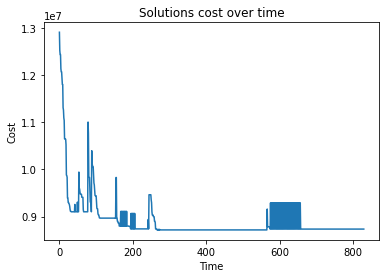

In [26]:
plt.plot(solutions)
plt.title('Solutions cost over time')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.show()


 ## Print the solution
 - Display routes
 - Display dropped nodes

In [27]:
dropped_ids = []
if solution:
    # Display routes
    total_distance = 0
    global_max_load = 0
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        print(f'Route for vehicle {vehicle_id}:')
        route_distance = 0
        max_route_load = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            time_var = time_dimension.CumulVar(index)
            print(f' {node_index} Load({route_load}) --Time({solution.Min(time_var)}, {solution.Max(time_var)})-->')
            route_distance += data['distance_matrix'][node_index][manager.IndexToNode(index)]
            max_route_load = max(route_load, max_route_load)
        node_index = manager.IndexToNode(index)
        print(f'{node_index} Load({route_load})\n')
        print(f'Distance of the route: {route_distance}m')
        print(f'Time of the route: {solution.Min(time_var)}min')
        total_distance += route_distance
        total_time += solution.Min(time_var)
        print(f'Max load of the route: {max_route_load}\n-------------')
        global_max_load = max(global_max_load, max_route_load)
    print(f'Total distance of all routes: {total_distance}m')
    print(f'Total time of all routes: {total_time}min')
    print(f'Maximum load for all vehicles: {global_max_load}')
    print('=====================')
    # Display dropped nodes.
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_ids.append(manager.IndexToNode(node))
    print(f'Dropped nodes: {dropped_ids if dropped_ids else None}')
else:
    print('No solution found')


Route for vehicle 0:
 0 Load(0) --Time(8, 8)-->
 5 Load(6) --Time(17, 17)-->
 9 Load(0) --Time(21, 21)-->
 23 Load(0) --Time(26, 26)-->
 22 Load(0) --Time(28, 28)-->
 24 Load(0) --Time(34, 34)-->
 18 Load(0) --Time(42, 42)-->
0 Load(0)

Distance of the route: 19201m
Time of the route: 42min
Max load of the route: 6
-------------
Route for vehicle 1:
 0 Load(0) --Time(9, 9)-->
 4 Load(5) --Time(13, 13)-->
 16 Load(11) --Time(16, 16)-->
 17 Load(11) --Time(20, 20)-->
 14 Load(5) --Time(28, 28)-->
 19 Load(5) --Time(34, 34)-->
 3 Load(0) --Time(42, 42)-->
0 Load(0)

Distance of the route: 19228m
Time of the route: 42min
Max load of the route: 11
-------------
Route for vehicle 2:
 0 Load(0) --Time(15, 15)-->
 7 Load(3) --Time(28, 28)-->
 21 Load(3) --Time(44, 44)-->
 8 Load(0) --Time(49, 49)-->
0 Load(0)

Distance of the route: 18506m
Time of the route: 49min
Max load of the route: 3
-------------
Route for vehicle 3:
 0 Load(0) --Time(6, 6)-->
 2 Load(4) --Time(10, 10)-->
 10 Load(0) --T

 ## Visualize the solution

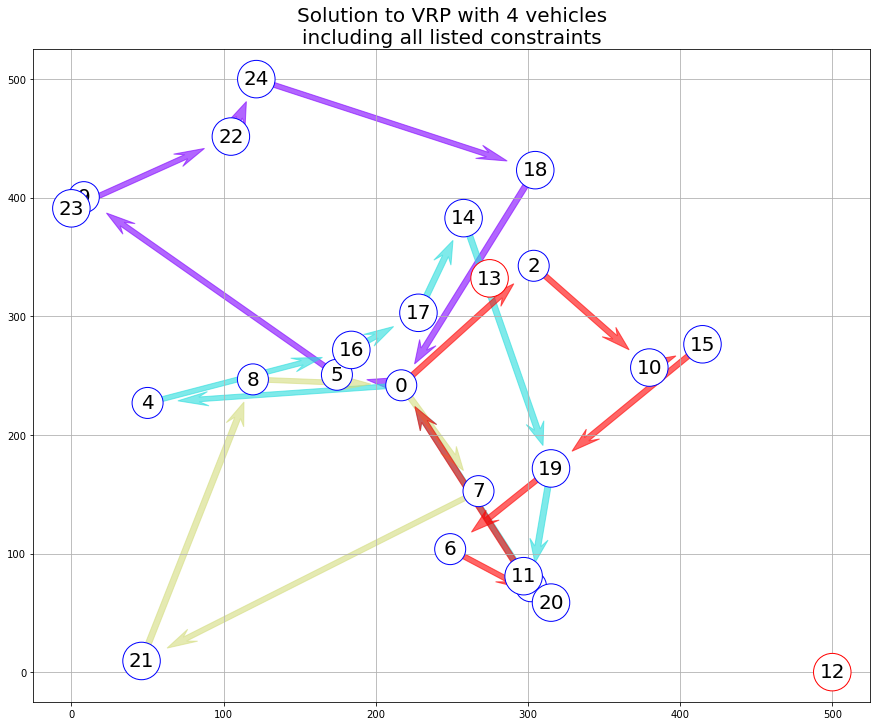

In [28]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.scatter(*locations.T)
marker_size = 20
for i, loc in enumerate(locations):
    ax.annotate(
        s=f"{i}", 
        xy=loc, 
        xycoords='data',
        va='center',
        ha='center',
        size=marker_size,
        bbox=dict(
            boxstyle='circle', 
            fc='w', 
            ec='blue' if i not in dropped_ids else 'red'
        )
    )
if solution:
    colors = plt.cm.rainbow(np.linspace(0, 1, data['num_vehicles']))
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            arrow = np.array([
                locations[manager.IndexToNode(previous_index)], 
                locations[manager.IndexToNode(index)] - locations[manager.IndexToNode(previous_index)]
            ])
            arrow_length = np.linalg.norm(arrow[1])
            arrow_scale = (arrow_length - marker_size) / arrow_length
            ax.arrow(
                *arrow[0],
                *(arrow[1] * arrow_scale),
                color=colors[vehicle_id],
                alpha=.6,
                label=f'Vehicle {vehicle_id}',
                width=4,
                head_width=12,
                head_length=20,
                overhang=.3,
                length_includes_head=True,
            )
    ax.grid(which='both')
    ax.set_title(f'Solution to VRP with {data["num_vehicles"]} vehicles\nincluding all listed constraints', fontsize=20)
    plt.show()
